In [1]:
import glob
import json
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np

In [2]:
with open('config.json', 'r') as f:
    settings = json.load(f)

In [3]:
results_dict = {}

In [4]:
def gather_results(results_dict, log_file_path):
    """
    """
    
    log_file = '/'.join(log_file_path.split('/')[-2:])
    results_dict[log_file] = {}

    with open(log_file_path, 'r') as f:
        data = f.read()
    data = data.strip().split('\n')
    for i, line in enumerate(data):
        if '#Parameter' in line:
            results = [data[i+2:i+7]][0]
        if 'Retrieval Execution Time' in line:
            results_dict[log_file]['total_time'] = line.split()[-1]
      
    # Gather ancillary data
    results_dict[log_file]['machine_type'] = log_file.split('/')[0]
    results_dict[log_file]['iteration'] = os.path.basename(log_file).split('.log')[0][-1]
    results_dict[log_file]['target'] = os.path.basename(log_file).split('_')[1]
    results_dict[log_file]['method'] = os.path.basename(log_file).split('_')[0]
    results_dict[log_file]['results'] = {}
    
    # Parse results in log file
    for item in results:
        item = item.split('INFO: ')[-1]
        parameter = item.split()[0]
        results_dict[log_file]['results'][parameter] = {}
        results_dict[log_file]['results'][parameter]['low_error'] = item.split()[1]
        results_dict[log_file]['results'][parameter]['median'] = item.split()[2]
        results_dict[log_file]['results'][parameter]['upper_error'] = item.split()[3]
        results_dict[log_file]['results'][parameter]['best_fit'] = item.split()[4]
    
    return results_dict

In [5]:
def get_total_times(results_dict, target, machine_type, method):
    """
    """
    
    total_times = []
    for log_file in results_dict:
        if target in log_file and machine_type in log_file and method in log_file:
            total_time = results_dict[log_file]['total_time']
            hours, minutes, seconds = total_time.split(':')
            total_seconds = (int(hours) * 3600) + (int(minutes) * 60) + int(seconds)
            total_times.append(total_seconds)
            
    average_time = np.mean(total_times)
            
    return average_time

In [6]:
log_files = glob.glob(os.path.join(settings['results_dir'], '*pu', '*.log'))
for log_file_path in log_files:
    results_dict = gather_results(results_dict, log_file_path)

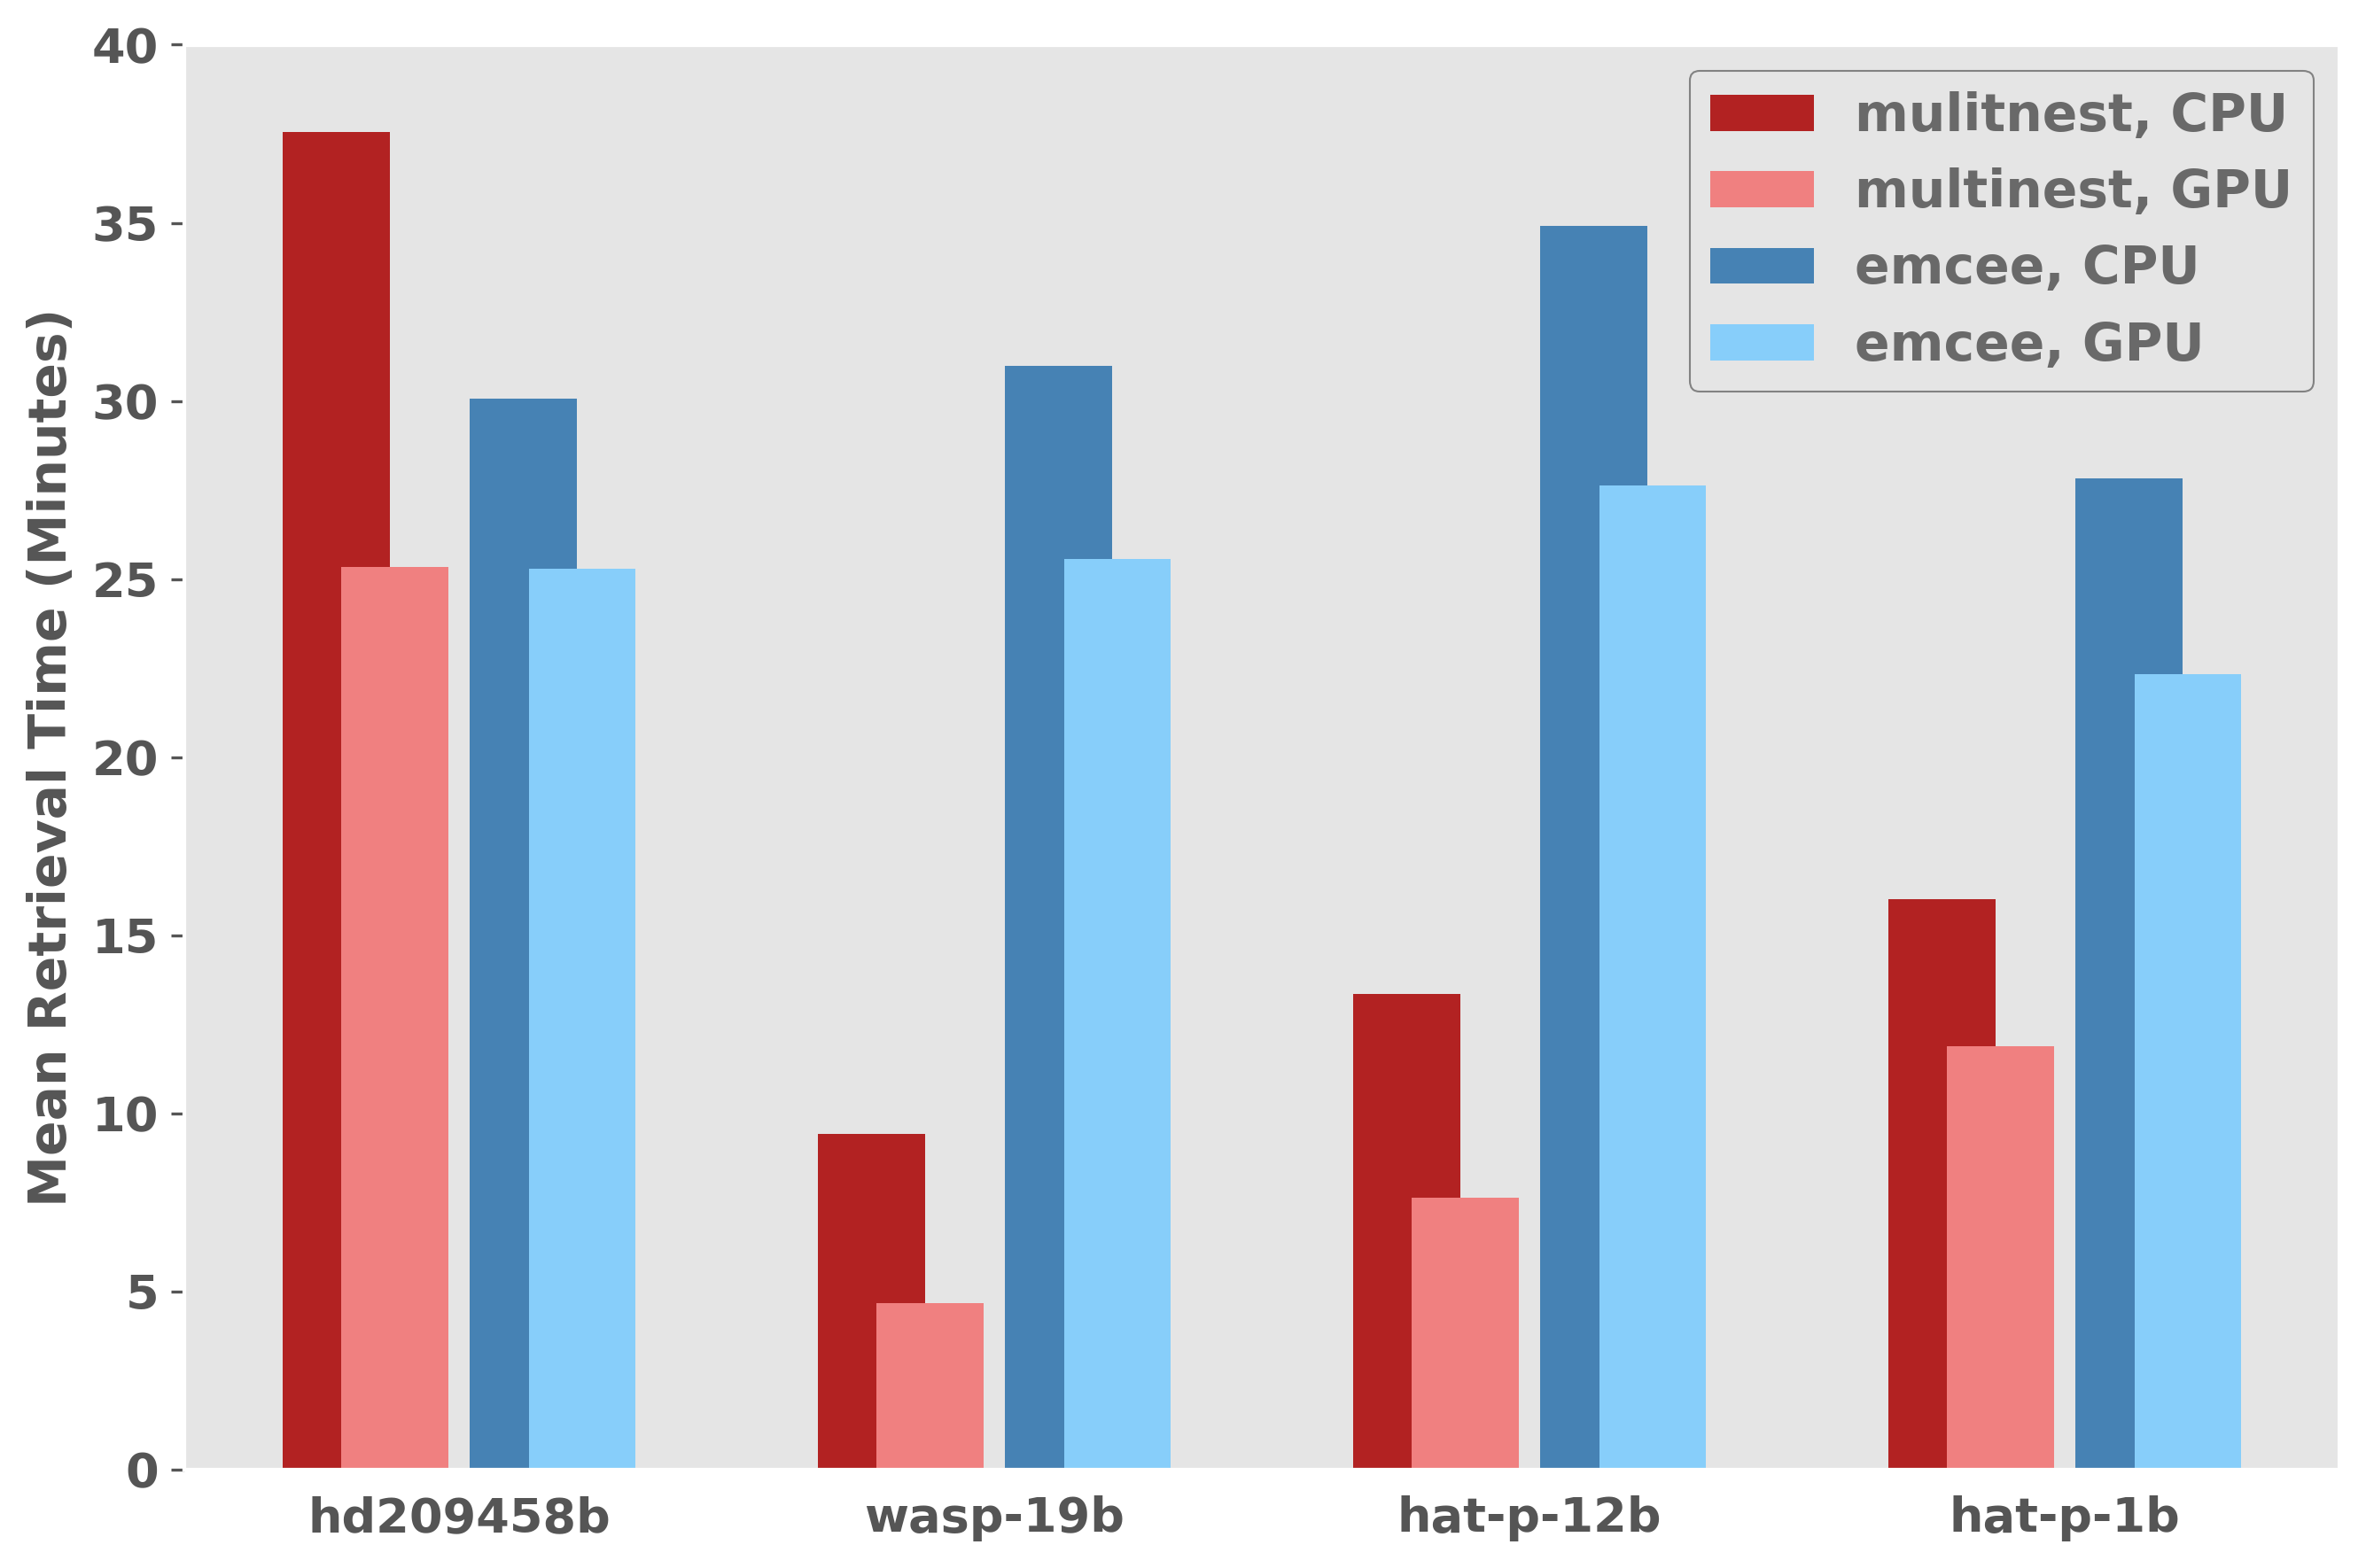

In [7]:
targets = ['hd209458b', 'wasp-19b', 'hat-p-12b', 'hat-p-1b']
cpu_multinest_times = [get_total_times(results_dict, target, 'cpu', 'multinest') for target in targets]
gpu_multinest_times = [get_total_times(results_dict, target, 'gpu', 'multinest') for target in targets]
cpu_emcee_times = [get_total_times(results_dict, target, 'cpu', 'emcee') for target in targets]
gpu_emcee_times = [get_total_times(results_dict, target, 'gpu', 'emcee') for target in targets]

groups = np.arange(4)
width = 0.2

plt.style.use('ggplot')
fig = plt.figure(figsize=(9, 6), dpi=300)
ax = fig.add_subplot(111)
ax.set_ylabel('Mean Retrieval Time (Minutes)', fontweight='bold', fontsize=14)

p1 = ax.bar(groups - 0.03 - width, cpu_multinest_times, width, color='firebrick', label='mulitnest, CPU')
p2 = ax.bar(groups - 0.03 - (0.45*width), gpu_multinest_times, width, color='lightcoral', label='multinest, GPU')
p3 = ax.bar(groups + 0.03 + (0.45*width), cpu_emcee_times, width, color='steelblue', label='emcee, CPU')
p4 = ax.bar(groups + 0.03 + width, gpu_emcee_times, width, color='lightskyblue', label='emcee, GPU')

ax.grid(False)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(('hd209458b', 'wasp-19b', 'hat-p-12b', 'hat-p-1b'), fontweight='bold')
ax.xaxis.set_ticks_position('none') 
ax.set_yticks([0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400])
ax.set_yticklabels(('0', '5', '10', '15', '20', '25', '30', '35', '40'), fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=13)
legend = plt.legend(edgecolor='dimgray', prop={'weight': 'bold', 'size': 14})
plt.setp(legend.get_texts(), color='dimgray')
plt.tight_layout()
plt.savefig('../figures/timing_results.png')